# MNIST classification using keras

The goal of this exercise is to train a simple MLP on the MNIST digit classification dataset, the "Hello World!" of machine learning. MNIST was created by Yann LeCun to benchmark supervised learning algorithms. State-of the art is at 99.7% accuracy on the test set (using convolutional deep networks). See this link to see the different approaches : <http://yann.lecun.com/exdb/mnist>

In MNIST, each input is a 28x28 grayscale image representing digits between 0 and 9. The training set has 60.000 examples, the test set 10.000.

Instead of programming explicitly the MLP like in the previous exercise, we will now use **Keras** <https://keras.io>, a high-level API to **tensorflow** <https://tensorflow.org>.

You need first to install `tensorflow` 2.x if not done already. On Colab, tensorflow is already installed. Even if you are using Anaconda, it is recommended to install tensorflow with pip:

```bash
pip install tensorflow
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.__version__)

2.3.1


**Q:** Read the documentation of keras at <https://keras.io/api/> to get an overview of its structure.

## Basic model

You are provided with a basic poor-performing keras model to get you started. The goal is to extend this model in order to obtain a satisfying accuracy on the test set. 

### Data preprocessing

The first step is to download the MNIST dataset. You could download the raw data from <http://yann.lecun.com/exdb/mnist> and process it, but that would take a while.

Fortunately, keras comes with a utility to automatically download MNIST, split it into training and test set and create nice numpy arrays:

In [2]:
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()

Have a look at the doc of `tf.keras.datasets` to see what other datasets you can simply use.

**Q:** Print the shape of the four numpy arrays `(X_train, t_train), (X_test, t_test)` and visualize some training examples to better understand what you are going to work on.

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)
x: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  83 149   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 104 245   9   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  32 254  40   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  66  68   0   0   0   0   0  15 232 144   0
    0   0   0   0   0   0   

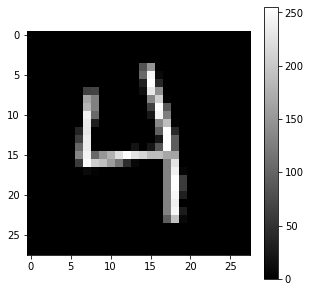

In [3]:
print("Training data:", X_train.shape, t_train.shape)
print("Test data:", X_test.shape, t_test.shape)

idx = 682 # for example
x = X_train[idx, :]
t = t_train[idx]
print("x:", x)
print("x (shape):", x.shape)
print("t:", t)

plt.figure(figsize=(5, 5))
plt.imshow(x, cmap="gray")
plt.colorbar()
plt.show()

In this exercise, we are going to use a regular MLP (with fully-connected layers). Convolutional layers will be seen next time.

We therefore need to transform the 28x28 input matrix into a 784 vector. Additionally, pixel values are integers between 0 and 255. We have to rescale them to floating values in [0, 1].

In [4]:
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.

We saw in the last exercise that **mean removal** is crucial when training a neural network. The following cell removes the mean image of the training set from all examples.

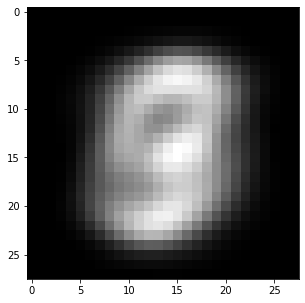

In [5]:
X_mean = np.mean(X_train, axis=0)
X_train -= X_mean
X_test -= X_mean


plt.figure(figsize=(5, 5))
plt.imshow(X_mean.reshape((28, 28))*255, cmap="gray")
plt.show()

The last preprocessing step is to perform **one-hot encoding** of the output labels. We want for example the digit 4 (index 5 in the outputs t) to be represented by the vector:

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

`keras` offers the utility `utils.to_categorical` to do that on the whole data:

In [6]:
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

print(T_train[idx])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


All set! The data is ready to be learned by a neural network. You should normally not have to re-run those cells again. If you do, do not forget to run all of them sequentially: 

### Model definition

Let's now define a simple MLP with keras. When using a notebook, you can recreate models by simply re-running the cell, but this does not delete the previous networks which may end up filling your RAM. It is therefore good practice to start by telling tensorflow to delete all previous models (if this is what you want):

```python
tf.keras.backend.clear_session()
```

One way to define a neural network in keras is by stacking layers in a `Sequential()` model (you can later have a look at the doc of `Model()` for directed acyclic graphs).

```python
model = tf.keras.models.Sequential()
```

The input layer has 784 neurons, one per pixel in the input image. We only need to define a placeholder of the correct size to represent inputs and `add()` it to the model as its first layer:

```python
model.add(tf.keras.layers.Input(shape=(784,)))
```

The input layer goes into a hidden, fully-connected, layer of 100 neurons using the logistic (or sigmoid) transfer function This can be specified by adding to the model a `Dense` layer (in the sense "fully-connected") with 100 units (another name for neuron), followed by an `Activation` layer using the 'sigmoid' function:

```python
model.add(tf.keras.layers.Dense(units=100))
model.add(tf.keras.layers.Activation('sigmoid')) 
```

The weight matrix and the biases are intialized automatically using the Glorot uniform scheme (seen in the last exercise) for the weights and zeros for the biases. Check the doc of the `Dense` layer to see how to change this: <https://keras.io/layers/core/#dense>.

We then add a softmax layer as output layer (classification problem), with 10 units (one per digit):

```python
model.add(tf.keras.layers.Dense(units=10))
model.add(tf.keras.layers.Activation('softmax')) 
```

Weights and biases are initialized in the same manner. That's all, keras now knows how to transform the input vector into class probabilities using randomly initialized weights!

For training, we need to choose an optimizer (learning rule). Several optimizers are available (<https://keras.io/optimizers/>). We pick simply **Stochastic Gradient Descent** with a learning rate of 0.01:

```python
optimizer = tf.keras.optimizers.SGD(lr=0.01)
```

The last step is to **compile** the network, so that keras computes how to implement the backpropagation algorithm. You need to specify:

1. which loss function you want to minimize. The full list is at <https://keras.io/losses/>. Here, we will use the cross-entropy loss function as we have a clasification problem with softmax outputs.
2. which optimizer you want to use.
3. which metrics (accuracy, error, etc. - <https://keras.io/metrics/>) you want to track during learning.

After the call to `compile()`, the neural network is instantiated and ready to learn.

In [7]:
# Delete all previous models to free memory
tf.keras.backend.clear_session()

# Sequential model
model = tf.keras.models.Sequential()

# Input layer representing the 784 pixels
model.add(tf.keras.layers.Input(shape=(784,)))

# Hidden layer with 100 logistic neurons
model.add(tf.keras.layers.Dense(units=100))
model.add(tf.keras.layers.Activation('sigmoid')) 

# Softmax output layer over 10 classes
model.add(tf.keras.layers.Dense(units=10))
model.add(tf.keras.layers.Activation('softmax')) 

# Learning rule
optimizer = tf.keras.optimizers.SGD(lr=0.01)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss function
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)

A good practice after creating the model is to call `model.summary()` to see how many layers you have created and how many parameters each layer has.

**Q:** Explain why you obtain this numbers of parameters in each layer.

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


**A:** the hidden layer has a weight matrix of size 784x100 and 100 biases, what makes 78500 free parameters. The output layer has a weight matrix of size 100x10 and 10 biases, so 1010 parameters.

Note that we have more free parameters than training examples, we are going to have to regularize quite hard...

### Model training

Now is time to train the network on MNIST. The following cell creates a `History()` object that will record the progress of your network.

It then calls the `model.fit()` method, which tells the network to learn the MNIST dataset defined by the `(X_train, Y_train)` arrays. You have to specify:

1. the batch size, i.e. the number of training examples in each minibatch used by SGD.
2. the maximal number of epochs for training
3. the size of the validation, taken from the training set to track the progress (this is not the test set!). Here we reserve 10% of the training data to validate. If you do not have much data, you could set it to 0.
4. a callback, which will be called at the end of each epoch. Here it will save the metrics defined in `model.compile()` in the `History()` object.

The training process can take a while depending on how big your network is and how many data samples you have. You can interrupt the kernel using the menu if you want to stop the processing in the cell.

In [9]:
# History tracks the evolution of the metrics during learning
history = tf.keras.callbacks.History()

# Training procedure
model.fit(
    X_train, T_train, # training data
    batch_size=128,  # batch size
    epochs=20, # Maximum number of epochs
    validation_split=0.1, # Perceptage of training data used for validation
    callbacks=[history] # Track the metrics at the end of each epoch
)

Epoch 1/20
422/422 [==============================] - 4s 10ms/step - loss: 2.0625 - accuracy: 0.4776 - val_loss: 1.7995 - val_accuracy: 0.7108
Epoch 2/20
422/422 [==============================] - 3s 6ms/step - loss: 1.6193 - accuracy: 0.7173 - val_loss: 1.3912 - val_accuracy: 0.7863
Epoch 3/20
422/422 [==============================] - 3s 8ms/step - loss: 1.2816 - accuracy: 0.7747 - val_loss: 1.0941 - val_accuracy: 0.8302
Epoch 4/20
422/422 [==============================] - 3s 6ms/step - loss: 1.0474 - accuracy: 0.8076 - val_loss: 0.8952 - val_accuracy: 0.8570
Epoch 5/20
422/422 [==============================] - 3s 7ms/step - loss: 0.8908 - accuracy: 0.8261 - val_loss: 0.7615 - val_accuracy: 0.8718
Epoch 6/20
422/422 [==============================] - 4s 11ms/step - loss: 0.7836 - accuracy: 0.8390 - val_loss: 0.6684 - val_accuracy: 0.8812
Epoch 7/20
422/422 [==============================] - 4s 9ms/step - loss: 0.7073 - accuracy: 0.8476 - val_loss: 0.6014 - val_accuracy: 0.8867
Epoc

The training has now run for 20 epochs on the training set. You see the evolution of loss function and accuracy for both the training and validation sets.

To test your trained model on the test set, you can call `model.evaluate()`:

In [10]:
score = model.evaluate(X_test, T_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3913428783416748
Test accuracy: 0.8964999914169312


You can also use the `History()` object to visualize the evolution of the the training and validation accuracy during learning.

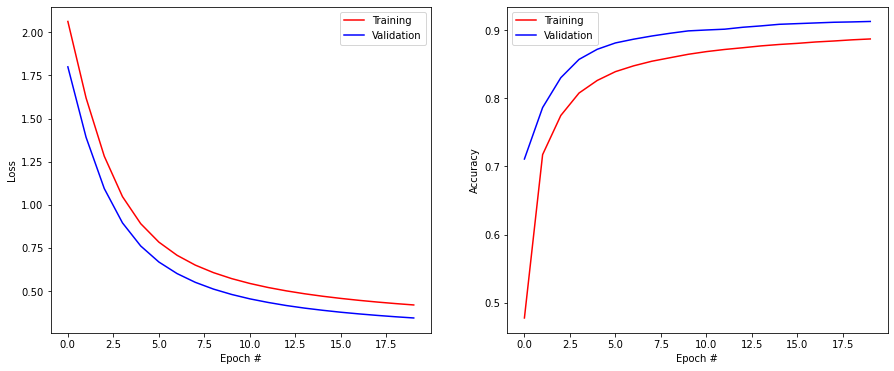

In [11]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Q:** Did overfitting occur during learning? Why? Looking at the curves, does it make sense to continue learning for much more epochs?

**A:**  No, the training accuracy is always below the validation accuracy. The model is too small to overfit. The accuracy has started saturating, it will not get much better (perhaps one percent or two) or very slowly (you can let it learn for 500 epochs or more to see it).

The following cell makes predictions on the test set (`model.predict(X_test)`), computes the predicted classes by looking at the maximum probability for each example and displays some misclassified examples. The title of each subplot denotes the predicted class and the ground truth.

**Q:** Are some mistakes understandable?

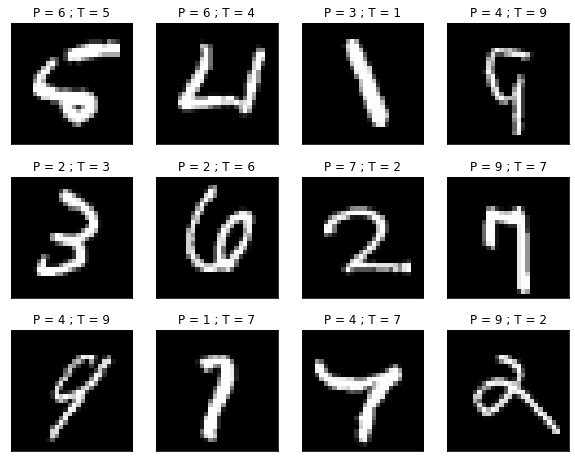

In [12]:
Y_test = model.predict(X_test)
c_test = np.argmax(Y_test, axis=-1)

misclassification = (c_test != t_test).nonzero()[0]

plt.figure(figsize=(10, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow((X_test[misclassification[i], :] + X_mean).reshape((28, 28)), cmap=plt.cm.gray, interpolation='nearest')
    plt.title('P = ' + str(c_test[misclassification[i]]) + ' ; T = ' + str(t_test[misclassification[i]]))
    plt.xticks([]); plt.yticks([])
plt.show()

## Questions

With the provided model, you probably obtained a final accuracy on the test set around 90%. That is lame. The state-of-the-art performance is 99.7%.

The goal of this exercise is now to modify the network in order to obtain an accuracy of **98%** (or more) in 20 epochs only.

You are free to use any improvement on the basic model, using the doc of Keras. Here are some suggestions:

* Change the learning rate of SGD.

* Change the number of neurons in the hidden layer.

* Change the number of hidden layers (just stack another `Dense` layer in the model).

**Beware:** you do not have three weeks in front of you, so keep the complexity of your model in a reasonable range.

* Change the transfer function of the hidden neurons. See <https://keras.io/activations/> for the different possibilities in `keras`. Check in particular the Rectifier Linear Unit (ReLU).

* Change the learning rule. Instead of the regular SGD, use for example the Nesterov Momentum method:

```python
optimizer = tf.keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
```

or the Adam learning rule:

```python
optimizer = tf.keras.optimizers.Adam(lr=0.01)
```

* Change the batch size. What impact does it have on training time?

* Apply **L2- or L1-regularization** to the weight updates to avoid overfitting <https://keras.io/regularizers/>:

```python
model.add(tf.keras.layers.Dense(50, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
```

* Apply **dropout** regularization after each layer. Find a good level of dropout.

```python
model.add(tf.keras.layers.Dropout(0.5))
```

* Add **Batch normalization** between the fully-connected layer and the transfer function.

```python
model.add(tf.keras.layers.Dense(100)) # Weights
model.add(tf.keras.layers.BatchNormalization()) # Batch normalization
model.add(tf.keras.layers.Activation('relu')) # Transfer function
```

## Solution

Here is a proposal which obtains 98% accuracy in a reasonable time. There are many other possible solutions, perhaps you found even better... 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
activation (Activation)      (None, 150)               0         
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0

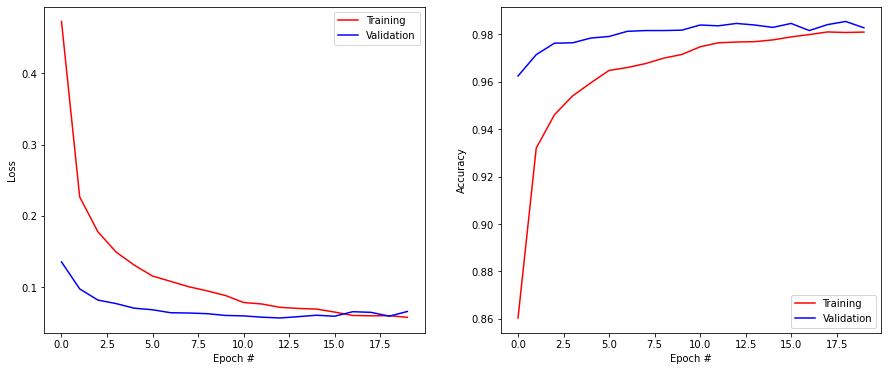

In [13]:
# Delete all previous models to free memory
tf.keras.backend.clear_session()

# Sequential model
model = tf.keras.models.Sequential()

# Input layer representing the 784 pixels
model.add(tf.keras.layers.Input(shape=(784,)))

# Hidden layer with 150 relu neurons, BN and dropout
model.add(tf.keras.layers.Dense(units=150))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.3)) 


# Second hidden layer with 100 relu neurons, BN and dropout
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.3))

# Softmax output layer over 10 classes
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))

# Learning rule
optimizer = tf.keras.optimizers.Adam(lr=0.001)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss function
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)

print(model.summary())

# Training
history = tf.keras.callbacks.History()
model.fit(
    X_train, T_train,
    batch_size=128, 
    epochs=20,
    validation_split=0.1,
    callbacks=[history]
)

# Testing
score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()